# Following Variational Inference with Joint Distributions in TensorFlow Probability

https://blog.tensorflow.org/2021/02/variational-inference-with-joint-distributions-in-tensorflow-probability.html

Emily Fertig, Joshua V. Dillon, Wynn Vonnegut, Dave Moore, and the TensorFlow Probability team, Feb 17, 2021

Oct 13, 2021

In [ ]:
#!pip3 install -q tf-nightly tfp-nightly

In [8]:
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
# Set tensor numeric type.
dtype = 'float32'

# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


TensorFlow version: 2.8.0-dev20211012
TensorFlow Probability version: 0.15.0-dev20211013


In [2]:
xname="sm_0.67"; yname="halo_mass"
xname="sm_1.0"; yname="halo_mass"; x2name="central_sm"

gal_df = pd.read_csv("Data/galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("Data/cluster_data_0.3-0.6.csv")
x_vector =  cluster_data[xname]; 
y_vector =  cluster_data[yname];
x2_vector = cluster_data[x2name]

# Set seed.
tf.random.set_seed(42)

# Tensors for tensorflow
# all the data

x = np.vstack([cluster_data[xname],cluster_data[x2name]]).transpose()
x = tf.convert_to_tensor(x, dtype=dtype)

y = tf.convert_to_tensor(cluster_data[yname], dtype=dtype)
y = tf.reshape(y, (-1, 1))
print("x shape: {}, y shape: {}".format(x.shape,y.shape))


x shape: (287, 2), y shape: (287, 1)


In [3]:

scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000,  contamination="auto", random_state=0)

# split into train and test sets
X=np.vstack([x_vector,x2_vector]).transpose()
X_train, X_test,  y_train, y_test = train_test_split(X, y_vector, train_size=160) # train_size=0.67)
print("train:  ",X_train.shape, y_train.shape," test:  ",  X_test.shape, y_test.shape)

if 1 == 0 : 
    # Scaling
    unit_df =pd.DataFrame(data={xname:X_train[:,0], x2name:X_train[:,1], yname:y_train})
    # Scale data to zero mean and unit variance.
    X_t = scaler.fit_transform(unit_df)
    print("X_t shape",X_t.shape)

    # Remove outliers.
    detector = IsolationForest(n_estimators=1000,  contamination=0.15, random_state=0)
    is_inlier = detector.fit_predict(X_t)
    X_t = X_t[(is_inlier > 0),:]
    unit_df =pd.DataFrame(data={xname:X_t[:,0], x2name:X_t[:,1], yname:X_t[:,2]})

    # Inverse scaling
    X_t = scaler.inverse_transform(unit_df)
    inv_df=pd.DataFrame(data={xname:X_t[:,0], x2name:X_t[:,1], yname:X_t[:,2]})
    xc=X_t[:,0]
    x2c=X_t[:1]
    yc=X_t[:,2]
    
    # Tensors for tensorflow
    # Just the train data
    x = np.vstack([inv_df[xname],inv_df[x2name]]).transpose()
    x = tf.convert_to_tensor(x, dtype=dtype)

    y = tf.convert_to_tensor(inv_df[yname], dtype=dtype)
    y = tf.reshape(y, (-1, 1))
else :

    # Tensors for tensorflow
    # Just the train data
    x = tf.convert_to_tensor(X_train, dtype=dtype)

    y = tf.convert_to_tensor(y_train, dtype=dtype)
    y = tf.reshape(y, (-1, 1))

xt, yt = x,y
x,y = tf.identity(xt), tf.identity(yt)
#x = tf.reshape(x, (5,1,32,-1))
#y = tf.reshape(y, (5,1,32,-1))

print("xt shape: {}, yt shape: {}".format(xt.shape,yt.shape))
print("x shape: {}, y shape: {}".format(x.shape,y.shape))




train:   (160, 2) (160,)  test:   (127, 2) (127,)
xt shape: (160, 2), yt shape: (160, 1)
x shape: (160, 2), y shape: (160, 1)


In [4]:
# Define the probabilistic graphical model as a JointDistribution.
def out_y (alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma, name="y")

@tfd.JointDistributionCoroutineAutoBatched
def model():
    sigma = yield tfd.HalfNormal(scale=1.0, name="sigma")
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    y = yield  out_y(alpha, beta, sigma, x)

target_model = model.experimental_pin(y=y)


print("model.event_shape: \n",model.event_shape)
print( target_model.event_shape_tensor())

if 1==0 :
    print("model._flat_resolve_names: \n",model._flat_resolve_names())
    print("model.event_shape: \n",model.event_shape)
    #print("model.batch_shape: \n",model.batch_shape)
    print("model.non_trainable_variables: ",model.non_trainable_variables)
    print("model.trainable_variables: ",model.trainable_variables)
    print("model.variables: ",model.variables)
    print("model.event_shape_tensor(): \n",model.event_shape_tensor())
    print("model.batch_shape_tensor(): \n",model.batch_shape_tensor())
    #print("model.experimental_sample_and_log_prob(): \n",model.experimental_sample_and_log_prob())
    print("model.log_prob(): \n",model.log_prob(model.sample()))
    print(". ")
    print("model.unnormalized_log_prob(): \n",model.unnormalized_log_prob(model.sample()))

model.event_shape: 
 StructTuple(
  sigma=TensorShape([]),
  alpha=TensorShape([]),
  beta=TensorShape([2]),
  y=TensorShape([160, 1])
)
StructTuple(
  sigma=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  alpha=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  beta=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>
)


## Multivariate Normal surrogate posterior

To build this surrogate posterior, a trainable linear operator is used to induce correlation among the components of the posterior.

We begin by constructing a base distribution with vector-valued standard Normal components, with sizes equal to the sizes of the corresponding prior components. The components are vector-valued so they can be transformed by the linear operator.

In [50]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()

#print(event_shape, "\n\n",flat_event_shape, "\n\n",flat_event_size)

base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])



To this distribution, we apply a trainable blockwise lower-triangular linear operator to induce correlation in the posterior. Within the linear operator, a trainable full-matrix block represents full covariance between two components of the posterior, while a block of zeros (or None) expresses independence. Blocks on the diagonal are either lower-triangular or diagonal matrices, so that the entire block structure represents a lower-triangular matrix.

Applying this bijector to the base distribution results in a multivariate Normal distribution with mean 0 and (Cholesky-factored) covariance equal to the lower-triangular block matrix.

In [58]:


# inducing covariance
if 1 == 0 :
    operators = (
        tf.linalg.LinearOperatorDiag,  # Variance of sigma. 
        tf.linalg.LinearOperatorDiag,  # Variance of alpha.
        tf.linalg.LinearOperatorDiag  # Variance of beta
    )
    print("operators shape:", np.shape(operators))

    operators = (
        (tf.linalg.LinearOperatorDiag,),  # Variance of sigma
        (tf.linalg.LinearOperatorFullMatrix,  # Covariance between sigma  and alpha.
             tf.linalg.LinearOperatorDiag),  # Variance of alpha.
        (None,  # Independence between sigma and beta.
             None,  #  Independence between alpha and beta.
             tf.linalg.LinearOperatorDiag)  # Independence among beta.
            #tf.linalg.LinearOperatorFullMatrix) # covariance among beta
    )

operators = (
    (tf.linalg.LinearOperatorDiag,),  # Variance of sigma
    (tf.linalg.LinearOperatorFullMatrix,  tf.linalg.LinearOperatorDiag),  # Variance of alpha.
     # Covariance between sigma  and alpha.
     (tf.linalg.LinearOperatorFullMatrix, tf.linalg.LinearOperatorFullMatrix,  tf.linalg.LinearOperatorLowerTriangular)
    # covariance beta+alpha                 covariance beta+sigma                 independence among beta
    )

print("operators shape:", np.shape(operators))

block_tril_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))


reshape_bijector = tfb.JointMap(
   tf.nest.map_structure(tfb.Reshape, flat_event_shape))
unflatten_bijector = tfb.Restructure(
       tf.nest.pack_sequence_as(
           event_shape, range(len(flat_event_shape))))
event_space_bijector = target_model.experimental_default_event_space_bijector()

# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))


print(event_space_bijector.forward_min_event_ndims)#, "\n",event_space_bijector.inverse_min_event_ndims)
print(unflatten_bijector.forward_min_event_ndims)#, "\n",unflatten_bijector.inverse_min_event_ndims)
print(reshape_bijector.forward_min_event_ndims)#, "\n",reshape_bijector.inverse_min_event_ndims)
print(loc_bijector.forward_min_event_ndims)#, "\n",loc_bijector.inverse_min_event_ndims)
print(scale_bijector.forward_min_event_ndims)#, "\n",scale_bijector.inverse_min_event_ndims)


operators shape: (3,)
StructTuple(
  sigma=0,
  alpha=0,
  beta=1
)
[0, 0, 0]
[1, 1, 1]
[0, 0, 0]
[1, 1, 1]


In [59]:
surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,  # allow for nonzero mean
         scale_bijector  # apply the block matrix transformation to the standard Normal distribution
         ]))



optimizing time: 193.770634 seconds
Multivariate Normal surrogate posterior ELBO: 95.66207885742188


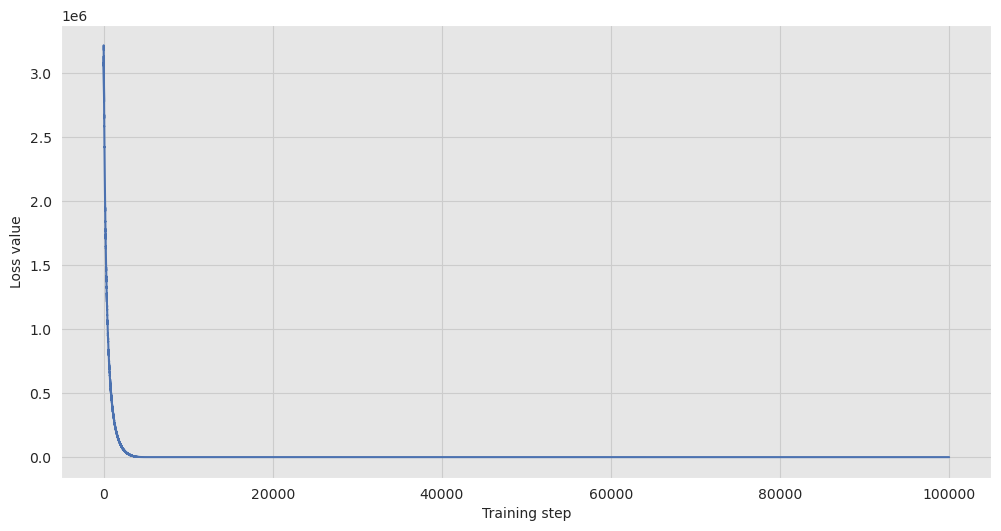

In [60]:
target_model = model.experimental_pin(y=y)

start = time.time()
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
mvn_loss = tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    surrogate_posterior,
    optimizer=optimizer,
    #num_steps=10**4,
    num_steps=10**5,
    sample_size=16)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

mvn_samples = surrogate_posterior.sample(1000)
mvn_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mvn_samples)
    - surrogate_posterior.log_prob(mvn_samples))

print('Multivariate Normal surrogate posterior ELBO: {}'.format(mvn_final_elbo))

plt.plot(mvn_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')



In [61]:
mvn_samples = surrogate_posterior.sample(10000)

sigma =mvn_samples[0].numpy()
alpha = mvn_samples[1].numpy()
beta = mvn_samples[2].numpy()

df = pd.DataFrame({"sigma":sigma,"alpha":alpha, "beta0":beta[:,0], "beta1":beta[:,1]})


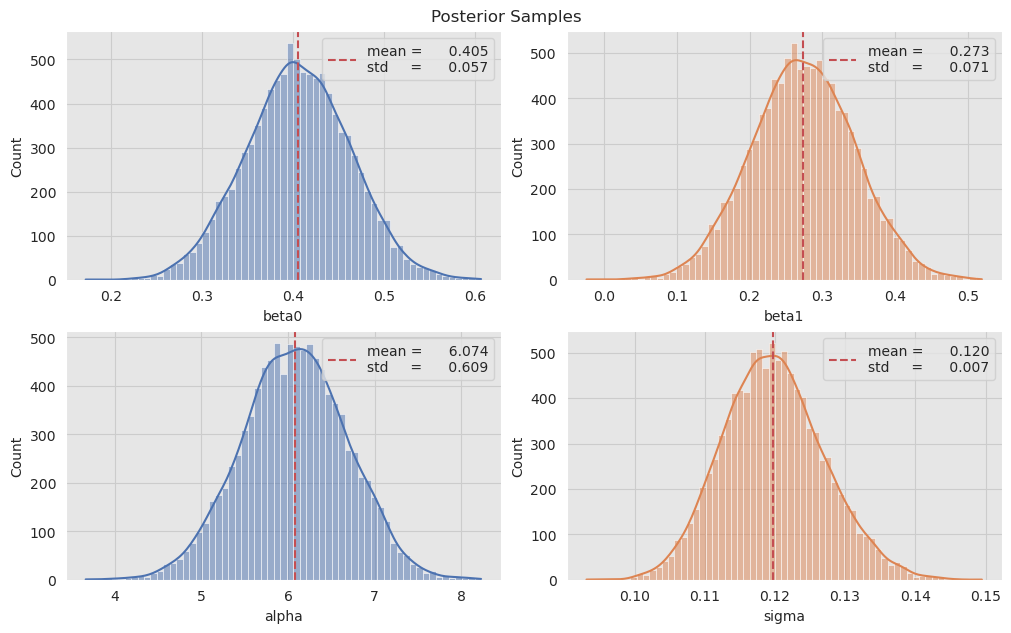

In [62]:
params=["beta0","beta1","alpha","sigma"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)

for param, i, j in zip(params, [0,1,0,1,],[0,0,1,1]):
    sns.histplot(x=param, data=df, color=sns_c[i], kde=True, ax=ax[j][i])
    ax[j][i].axvline(
        x=df[param].mean(), 
        color=sns_c[3], 
        linestyle='--',
        label='mean = {:10.3f}\nstd     = {:10.3f}'.format(df[param].mean(),df[param].std() )
    )
    ax[j][i].legend(loc='upper right')    
fig.suptitle('Posterior Samples', y=1.03);




On training data
posterior_std  chi-sq: 1.048
posterior delta,scatter: -0.034  0.120

On test data
posterior_std  chi-sq: 0.975
posterior delta,scatter: -0.030  0.120


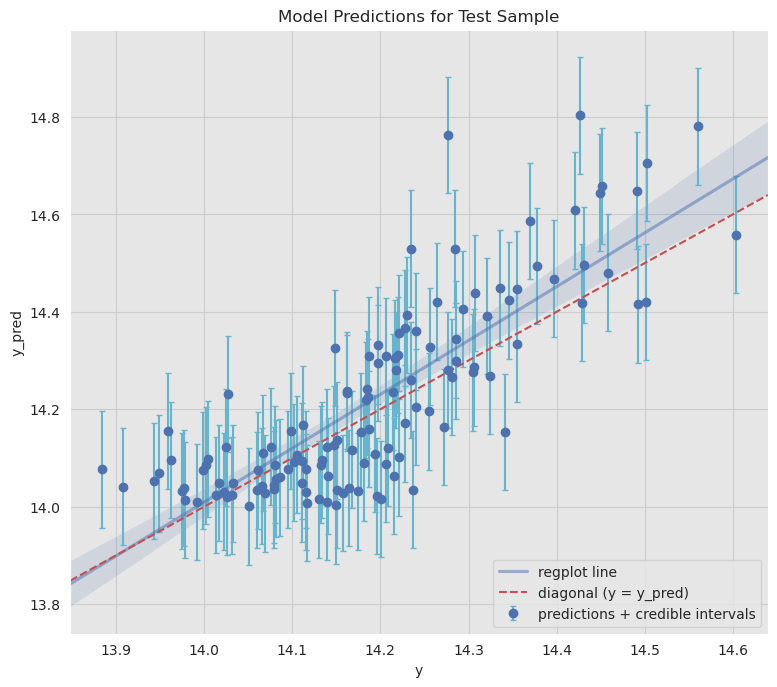

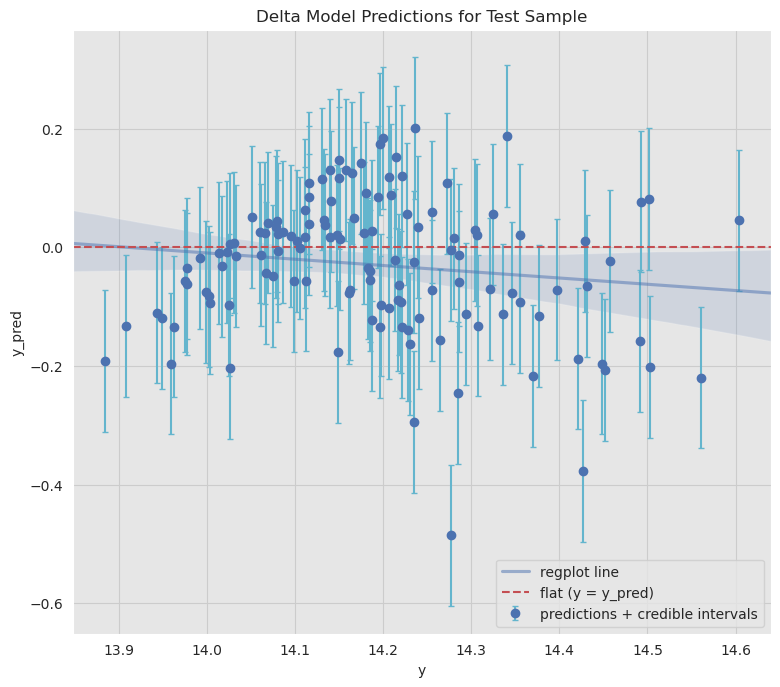

In [63]:
mvn_samples = surrogate_posterior.sample(10000)
sigma =mvn_samples[0]
alpha = mvn_samples[1]
beta = mvn_samples[2]

def get_y_predictions(alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)

xtr = tf.convert_to_tensor(X_train, dtype=dtype)
ytr = tf.convert_to_tensor(y_train, dtype=dtype)
ytr = tf.reshape(ytr, (-1, 1))
xte = tf.convert_to_tensor(X_test, dtype=dtype)
yte = tf.convert_to_tensor(y_test, dtype=dtype)
yte = tf.reshape(yte, (-1, 1))
ytr=np.squeeze(ytr.numpy())
yte=np.squeeze(yte.numpy())

y_model = get_y_predictions(alpha, beta, sigma, xtr)
y_model.sample()
y_model.stddev()
posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)
posterior_var = ( y_model.variance()).numpy().mean(axis=1)

#print(posterior_mean, posterior_std)
print("\nOn training data")
print("posterior_std  chi-sq: {:.3f}".format( ((posterior_mean-ytr)**2/posterior_var).sum()/ytr.size))
print("posterior delta,scatter: {:6.3f} {:6.3f}".format((posterior_mean-ytr).mean(), posterior_std.mean()))

y_model = get_y_predictions(alpha, beta, sigma, xte)
y_model.sample()
y_model.stddev()


posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)
posterior_var = ( y_model.variance()).numpy().mean(axis=1)
print("\nOn test data")
print("posterior_std  chi-sq: {:.3f}".format( ((posterior_mean-yte)**2/posterior_var).sum()/yte.size))
print("posterior delta,scatter: {:6.3f} {:6.3f}".format((posterior_mean-yte).mean(), posterior_std.mean()))

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar( x=posterior_mean, y=yte, yerr=posterior_std,
    fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)

sns.regplot(x=posterior_mean, y = yte,
    color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.set(title='Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
ax.legend(loc='lower right')
  
#print(posterior_mean.shape, yte.shape, posterior_std.shape)

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar( x=posterior_mean, y=posterior_mean-yte, yerr=posterior_std,
    fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)


sns.regplot(x=posterior_mean, y=posterior_mean-yte,
    color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
ax.axline(xy1=(14.0,0), slope=0, linestyle='--', color=sns_c[3], label='flat (y = y_pred)')
ax.set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
ax.legend(loc='lower right')



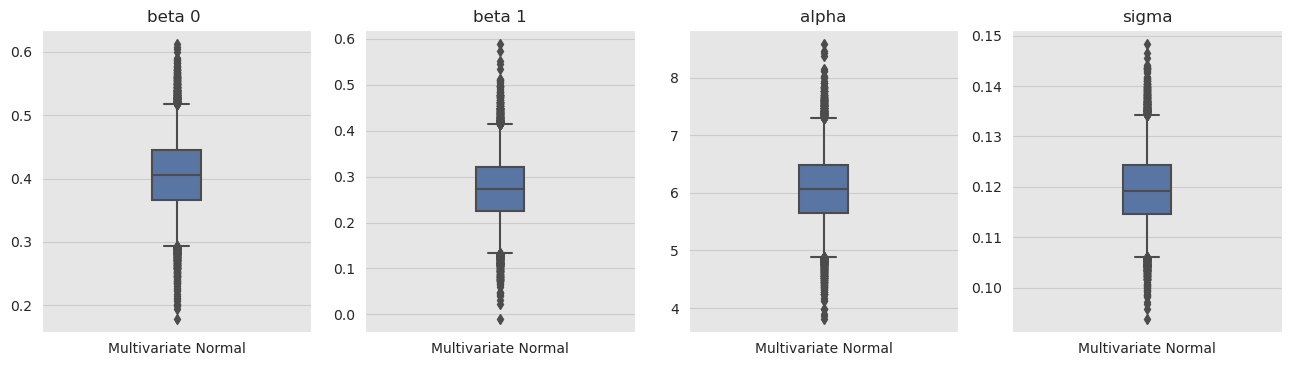

In [64]:
def pack_samples(samples):
  return {'beta 0 ': samples.beta[:,0],
          'beta 1': samples.beta[:,1],
          'alpha': samples.alpha,
          'sigma': samples.sigma}

def plot_boxplot(posterior_samples):
  fig, axes = plt.subplots(1, 4, figsize=(16, 4))

  # Invert the results dict for easier plotting.
  k = list(posterior_samples.values())[0].keys()
  plot_results = {
      v: {p: posterior_samples[p][v] for p in posterior_samples} for v in k}
  for i, (var, var_results) in enumerate(plot_results.items()):
    sns.boxplot(data=list(var_results.values()), ax=axes[i],
                width=0.18*len(var_results), whis=(2.5, 97.5))
    # axes[i].boxplot(list(var_results.values()), whis=(2.5, 97.5))
    axes[i].title.set_text(var)
    fs = 10 if len(var_results) < 4 else 8
    axes[i].set_xticklabels(list(var_results.keys()), fontsize=fs)

results = {'Multivariate Normal': pack_samples(mvn_samples)}
plot_boxplot(results)



## Change the form of the posterior surrogate to Mean Field

### Baseline: Mean-field surrogate posterior

VI surrogate posteriors are often assumed to be mean-field (independent) Normal distributions, with trainable means and variances, that are constrained to the support of the prior with a bijective transformation. We define a mean-field surrogate posterior in addition to the two more expressive surrogate posteriors, using the same general formula as the multivariate Normal surrogate posterior.

In [65]:
# A block-diagonal linear operator, in which each block is a diagonal operator,
# transforms the standard Normal base distribution to produce a mean-field
# surrogate posterior.
operators = (tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag)
block_diag_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
mean_field_scale = tfb.ScaleMatvecLinearOperatorBlock(block_diag_linop)

mean_field_loc = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

mean_field_surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector, # reshape the vector-valued components to match the shapes of the posterior components
         mean_field_loc,   # allow for nonzero mean
         mean_field_scale  # apply the block matrix transformation to the standard Normal distribution
         ]))



optimizing time: 10.217915 seconds
Mean-field surrogate posterior ELBO: 87.71431732177734


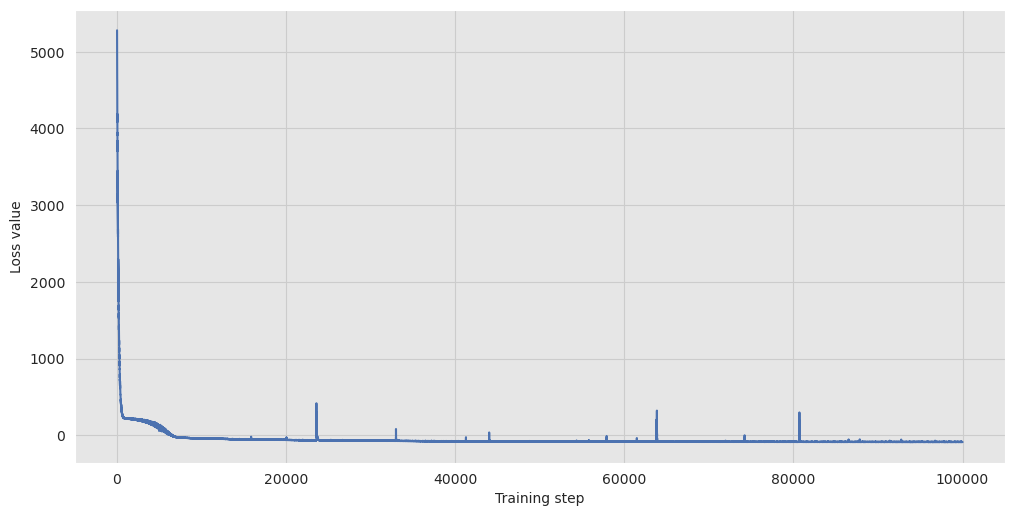

In [66]:
#tf.keras.backend.clear_session()
@tfd.JointDistributionCoroutineAutoBatched
def model2():
    sigma = yield tfd.HalfNormal(scale=1.0, name="sigma")
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    y = yield  out_y(alpha, beta, sigma, x)
target_model2 = model2.experimental_pin(y=y) 

start = time.time()
optimizer=tf.optimizers.Adam(learning_rate=1e-3)
mean_field_loss = tfp.vi.fit_surrogate_posterior(
    target_model2.unnormalized_log_prob,
    mean_field_surrogate_posterior,
    optimizer=optimizer,
    #num_steps=10**4,
    num_steps=10**5,
    sample_size=16,
    jit_compile=True)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

mean_field_samples = mean_field_surrogate_posterior.sample(1000)
mean_field_final_elbo = tf.reduce_mean(
    target_model2.unnormalized_log_prob(*mean_field_samples)
    - mean_field_surrogate_posterior.log_prob(mean_field_samples))
print('Mean-field surrogate posterior ELBO: {}'.format(mean_field_final_elbo))

plt.plot(mean_field_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')



In [242]:
print(mean_field_samples)


StructTuple(
  sigma=<tf.Tensor: shape=(1000,), dtype=float32, numpy=
    array([0.13116941, 0.10864235, 0.11877698, 0.1325193 , 0.12295354,
           0.12648301, 0.11600384, 0.1361889 , 0.13179436, 0.12345662,
           0.13106285, 0.12369405, 0.14446221, 0.12981594, 0.1363299 ,
           0.14547877, 0.13408521, 0.13452052, 0.15085557, 0.11848995,
           0.13599275, 0.12841637, 0.14403649, 0.12685436, 0.1316758 ,
           0.12018232, 0.13581842, 0.14821367, 0.1340228 , 0.12161973,
           0.12670346, 0.15332213, 0.12545578, 0.14171633, 0.15088171,
           0.13602817, 0.12571959, 0.14253393, 0.13739415, 0.11505749,
           0.14514792, 0.13379744, 0.12909786, 0.12655316, 0.13972616,
           0.13249317, 0.13287936, 0.11691304, 0.13942222, 0.13116242,
           0.12422846, 0.12737772, 0.1167748 , 0.1264439 , 0.13186087,
           0.12765053, 0.13503912, 0.13066044, 0.14205751, 0.14479792,
           0.13450196, 0.10899388, 0.14262295, 0.1338874 , 0.13263561,
       

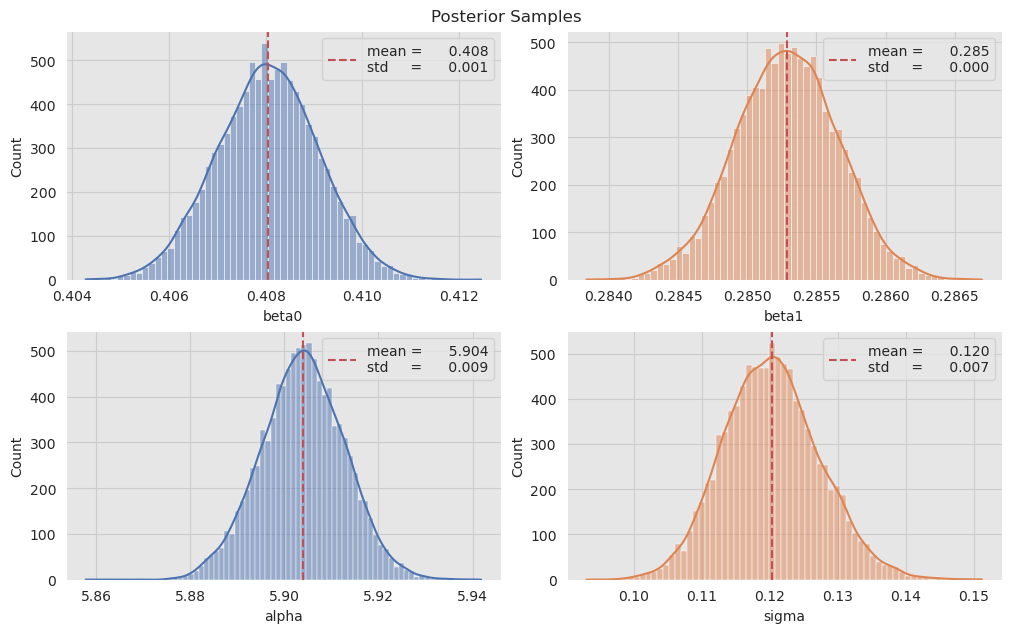

In [67]:
mvn_samples = mean_field_surrogate_posterior.sample(10000)

sigma =mvn_samples[0].numpy()
alpha = mvn_samples[1].numpy()
beta = mvn_samples[2].numpy()

df = pd.DataFrame({"sigma":sigma,"alpha":alpha, "beta0":beta[:,0], "beta1":beta[:,1]})

params=["beta0","beta1","alpha","sigma"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)

for param, i, j in zip(params, [0,1,0,1,],[0,0,1,1]):
    sns.histplot(x=param, data=df, color=sns_c[i], kde=True, ax=ax[j][i])
    ax[j][i].axvline(
        x=df[param].mean(), 
        color=sns_c[3], 
        linestyle='--',
        label='mean = {:10.3f}\nstd     = {:10.3f}'.format(df[param].mean(),df[param].std() )
    )
    ax[j][i].legend(loc='upper right')    
fig.suptitle('Posterior Samples', y=1.03);




On training data
posterior_std  chi-sq: 1.014
posterior delta,scatter: -0.029  0.120

On test data
posterior_std  chi-sq: 0.938
posterior delta,scatter: -0.024  0.120


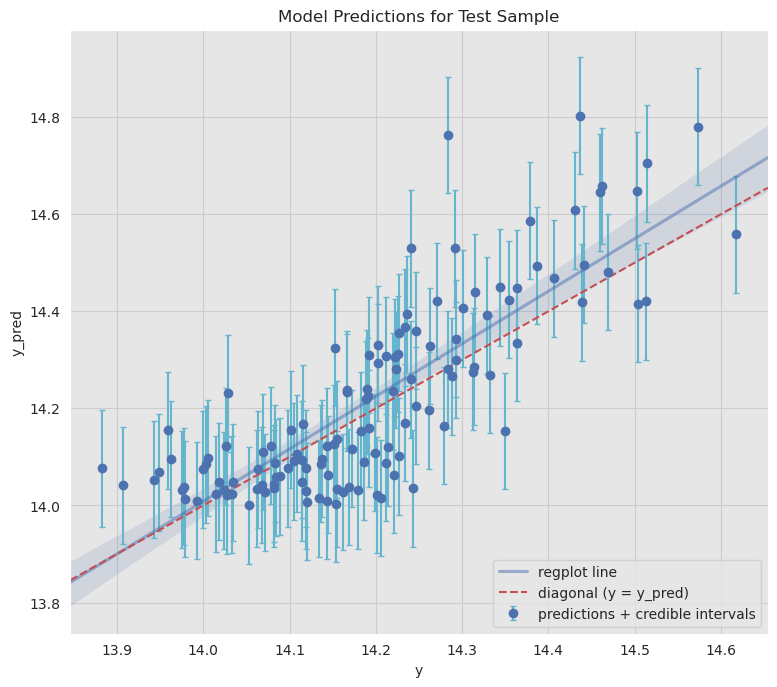

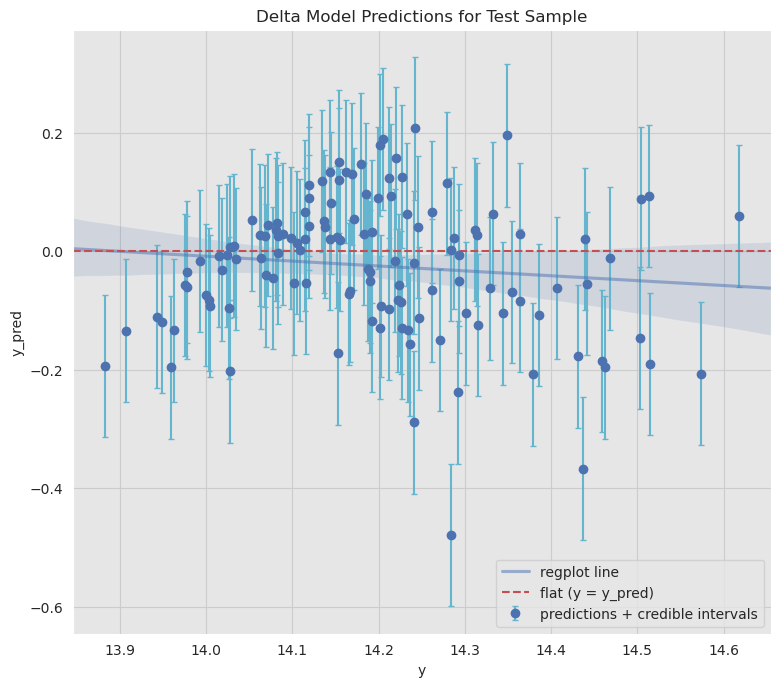

In [68]:

def get_y_predictions(alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)

xtr = tf.convert_to_tensor(X_train, dtype=dtype)
ytr = tf.convert_to_tensor(y_train, dtype=dtype)
ytr = tf.reshape(ytr, (-1, 1))
xte = tf.convert_to_tensor(X_test, dtype=dtype)
yte = tf.convert_to_tensor(y_test, dtype=dtype)
yte = tf.reshape(yte, (-1, 1))
ytr=np.squeeze(ytr.numpy())
yte=np.squeeze(yte.numpy())

y_model = get_y_predictions(alpha, beta, sigma, xtr)
y_model.sample()
y_model.stddev()
posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)
posterior_var = ( y_model.variance()).numpy().mean(axis=1)

#print(posterior_mean, posterior_std)
print("\nOn training data")
print("posterior_std  chi-sq: {:.3f}".format( ((posterior_mean-ytr)**2/posterior_var).sum()/ytr.size))
print("posterior delta,scatter: {:6.3f} {:6.3f}".format((posterior_mean-ytr).mean(), posterior_std.mean()))

y_model = get_y_predictions(alpha, beta, sigma, xte)
y_model.sample()
y_model.stddev()


posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)
posterior_var = ( y_model.variance()).numpy().mean(axis=1)
print("\nOn test data")
print("posterior_std  chi-sq: {:.3f}".format( ((posterior_mean-yte)**2/posterior_var).sum()/yte.size))
print("posterior delta,scatter: {:6.3f} {:6.3f}".format((posterior_mean-yte).mean(), posterior_std.mean()))

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar( x=posterior_mean, y=yte, yerr=posterior_std,
    fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)

sns.regplot(x=posterior_mean, y = yte,
    color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.set(title='Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
ax.legend(loc='lower right')
  
#print(posterior_mean.shape, yte.shape, posterior_std.shape)

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar( x=posterior_mean, y=posterior_mean-yte, yerr=posterior_std,
    fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)


sns.regplot(x=posterior_mean, y=posterior_mean-yte,
    color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
ax.axline(xy1=(14.0,0), slope=0, linestyle='--', color=sns_c[3], label='flat (y = y_pred)')
ax.set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
ax.legend(loc='lower right')


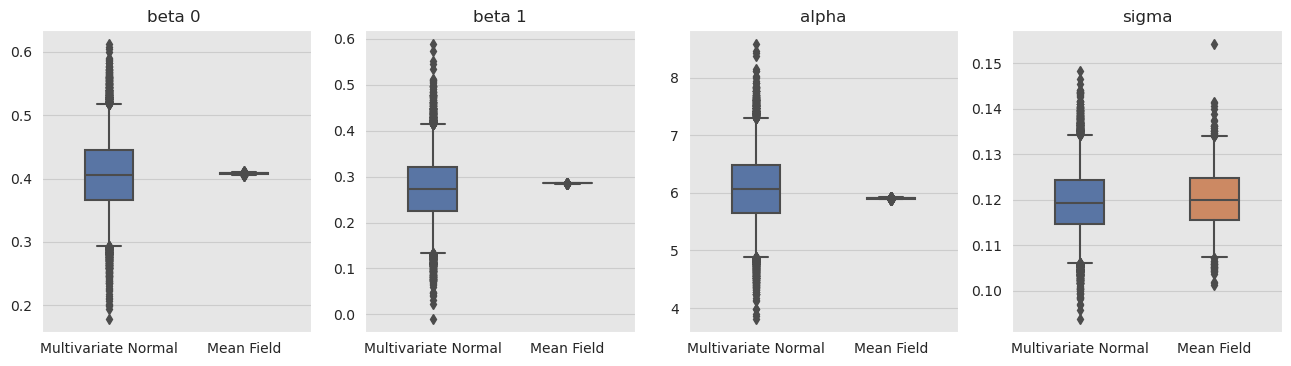

In [69]:
results['Mean Field'] = pack_samples(mean_field_samples)
plot_boxplot(results)



In [205]:
print("alpha samples: {},\n  sigma samples: {},\n beta samples {}".format(mvn_samples.alpha,mvn_samples.sigma,mvn_samples.beta))
print("beta shape: {},\n beta0 shape {},\n beta1 shape {}".format((mvn_samples.beta).shape, (mvn_samples.beta[:,0]).shape, (mvn_samples.beta[:,1]).shape))

alpha samples: [5.3788867 5.36015   5.37266   ... 5.377394  5.376065  5.4050264],
  sigma samples: [0.2101537  0.2180936  0.17295353 ... 0.17197096 0.22433846 0.15606841],
 beta samples [[0.43200395 0.3045104 ]
 [0.43128338 0.30541155]
 [0.4325732  0.30523524]
 ...
 [0.4344069  0.30471408]
 [0.43322057 0.30564523]
 [0.4323309  0.3069266 ]]
beta shape: (10000, 2),
 beta0 shape (10000,),
 beta1 shape (10000,)


## Change the form of the posterior surrogate to Inverse Autoregressive Flow surrogate posterior

In [70]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])

# Apply an IAF to the base distribution.
num_iafs = 2
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[256, 256], activation='relu')))
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
         split] +  # Split the samples into components of the same size as the prior components
         iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
         ))



Train the IAF surrogate posterior.

optimizing time: 145.130087 seconds
IAF surrogate posterior ELBO: 96.52529907226562


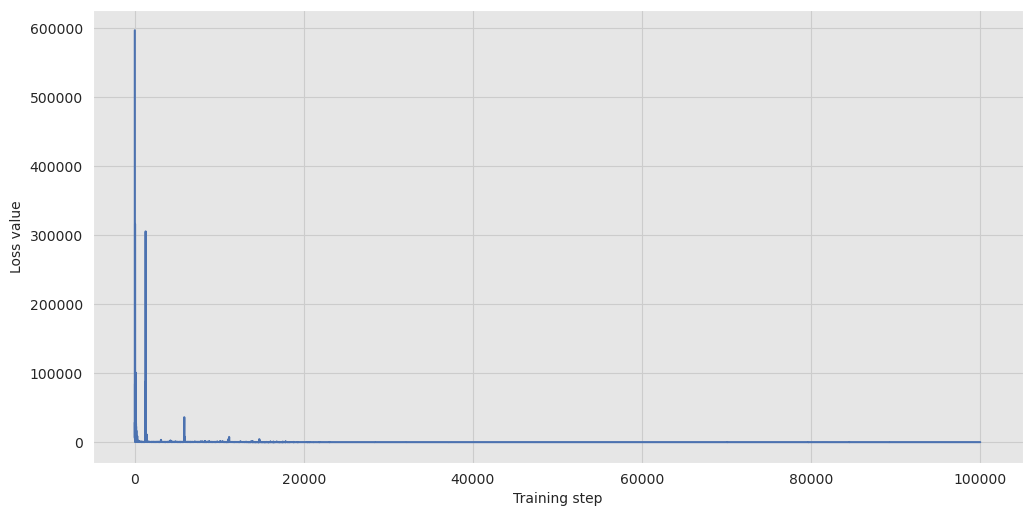

In [71]:
tf.keras.backend.clear_session()
@tfd.JointDistributionCoroutineAutoBatched
def model3():
    sigma = yield tfd.HalfNormal(scale=1.0, name="sigma")
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    y = yield  out_y(alpha, beta, sigma, x)
target_model3 = model3.experimental_pin(y=y)

start = time.time()
optimizer=tf.optimizers.Adam(learning_rate=1e-3)
iaf_loss = tfp.vi.fit_surrogate_posterior(
  target_model3.unnormalized_log_prob,
  iaf_surrogate_posterior,
  optimizer=optimizer,
  #num_steps=10**4,
  num_steps=10**5,
  sample_size=4,
  jit_compile=True)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model3.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')



In [72]:
print(iaf_surrogate_posterior.sample(10))



StructTuple(
  sigma=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([0.11588781, 0.12273422, 0.13186431, 0.11801459, 0.10977768,
           0.12298369, 0.11874511, 0.13006666, 0.13015136, 0.11294571],
          dtype=float32)>,
  alpha=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([5.981925 , 6.5559883, 6.4441805, 5.993084 , 6.6424294, 6.4599557,
           6.40056  , 6.1706553, 5.8477287, 6.6839976], dtype=float32)>,
  beta=<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
    array([[0.41978273, 0.265752  ],
           [0.406422  , 0.22961898],
           [0.43196008, 0.21435228],
           [0.3668464 , 0.3182177 ],
           [0.41577372, 0.21374463],
           [0.3884002 , 0.25744203],
           [0.44512045, 0.2020132 ],
           [0.37160152, 0.299338  ],
           [0.4471766 , 0.24969989],
           [0.39261177, 0.23393552]], dtype=float32)>
)


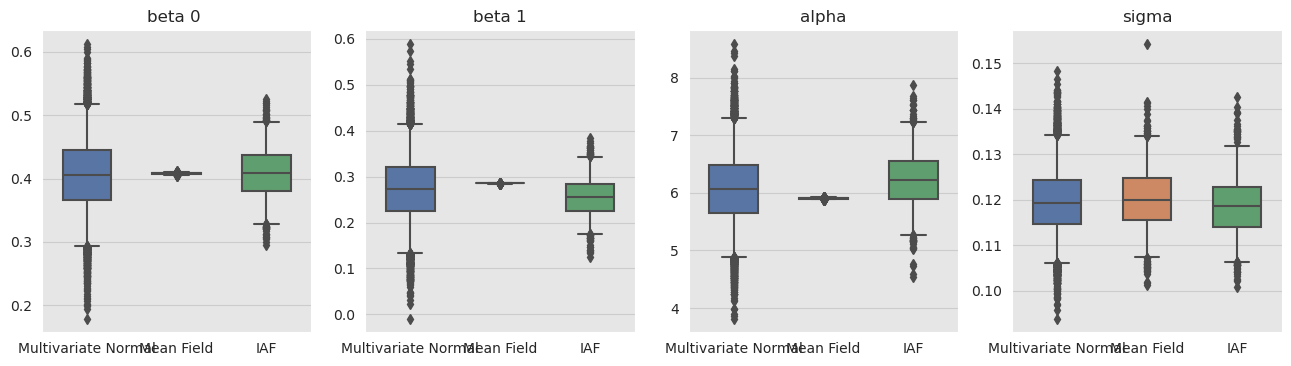

In [73]:
results['IAF'] = pack_samples(iaf_samples)
plot_boxplot(results)


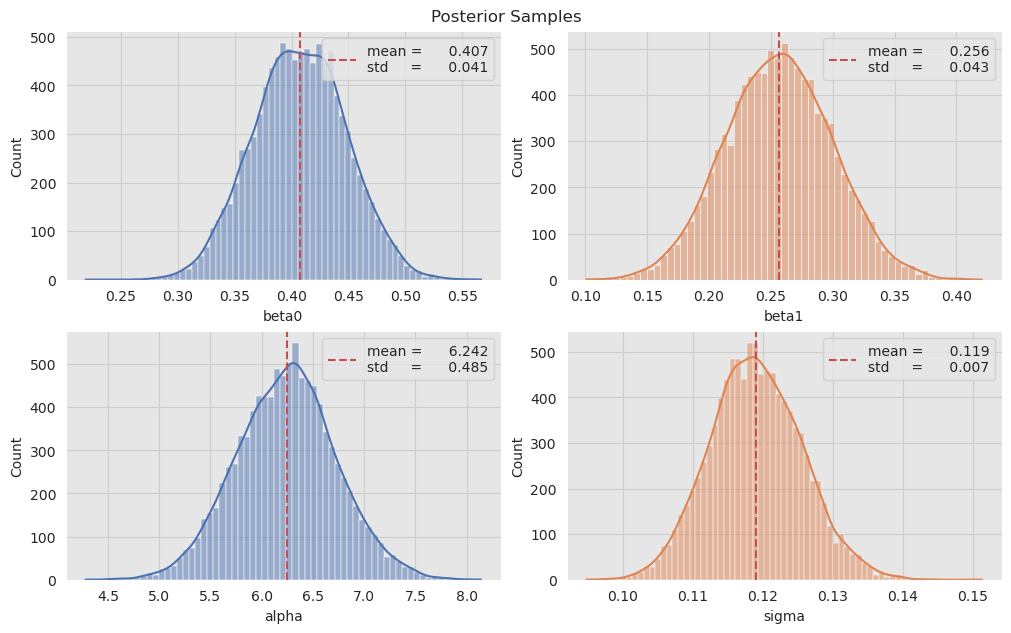

In [74]:
mvn_samples = iaf_surrogate_posterior.sample(10000)

sigma =mvn_samples[0].numpy()
alpha = mvn_samples[1].numpy()
beta = mvn_samples[2].numpy()

df = pd.DataFrame({"sigma":sigma,"alpha":alpha, "beta0":beta[:,0], "beta1":beta[:,1]})

params=["beta0","beta1","alpha","sigma"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)

for param, i, j in zip(params, [0,1,0,1,],[0,0,1,1]):
    sns.histplot(x=param, data=df, color=sns_c[i], kde=True, ax=ax[j][i])
    ax[j][i].axvline(
        x=df[param].mean(), 
        color=sns_c[3], 
        linestyle='--',
        label='mean = {:10.3f}\nstd     = {:10.3f}'.format(df[param].mean(),df[param].std() )
    )
    ax[j][i].legend(loc='upper right')    
fig.suptitle('Posterior Samples', y=1.03);




On training data
posterior_std  chi-sq: 1.125
posterior delta,scatter: -0.046  0.119

On test data
posterior_std  chi-sq: 1.054
posterior delta,scatter: -0.042  0.119


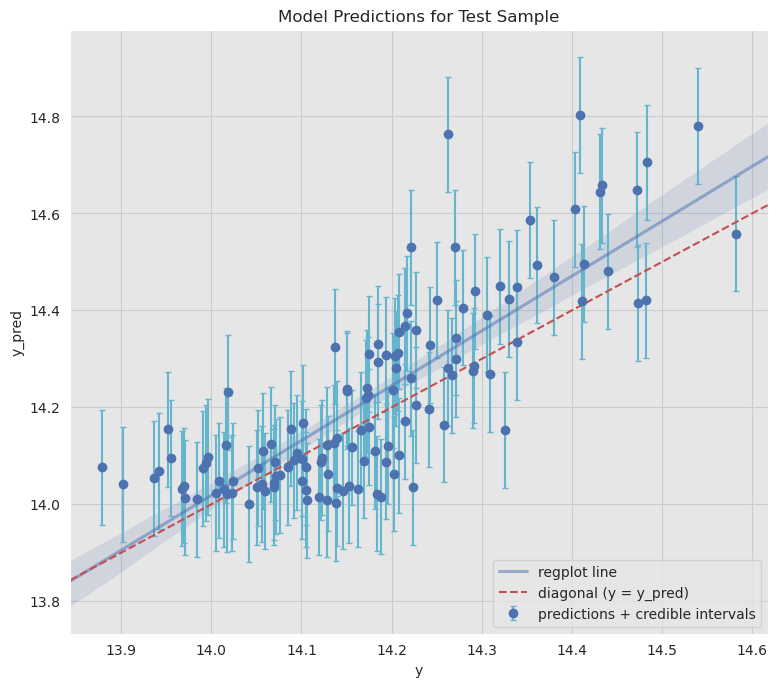

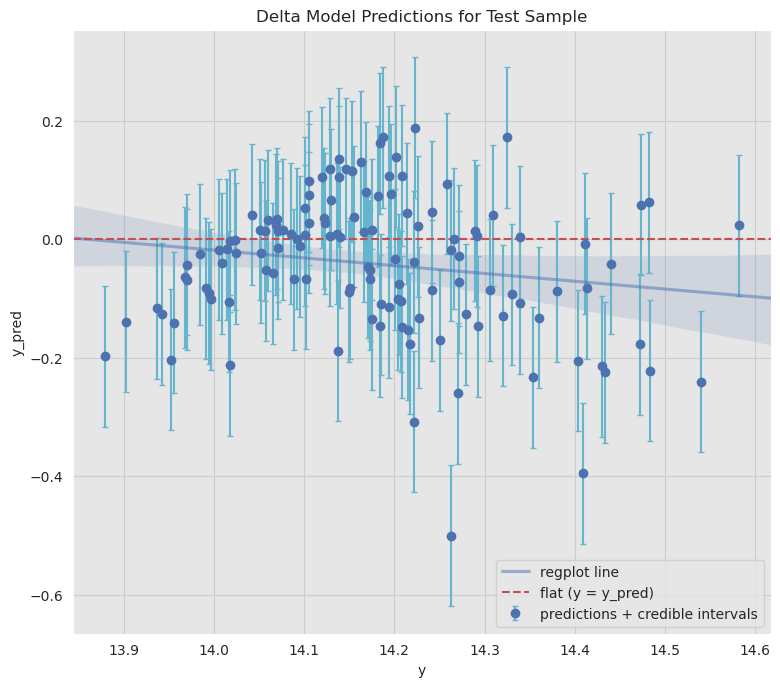

In [75]:
mvn_samples = iaf_surrogate_posterior.sample(10000)
sigma =mvn_samples[0]
alpha = mvn_samples[1]
beta = mvn_samples[2]

def get_y_predictions(alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)

xtr = tf.convert_to_tensor(X_train, dtype=dtype)
ytr = tf.convert_to_tensor(y_train, dtype=dtype)
ytr = tf.reshape(ytr, (-1, 1))
xte = tf.convert_to_tensor(X_test, dtype=dtype)
yte = tf.convert_to_tensor(y_test, dtype=dtype)
yte = tf.reshape(yte, (-1, 1))
ytr=np.squeeze(ytr.numpy())
yte=np.squeeze(yte.numpy())

y_model = get_y_predictions(alpha, beta, sigma, xtr)
y_model.sample()
y_model.stddev()
posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)
posterior_var = ( y_model.variance()).numpy().mean(axis=1)

#print(posterior_mean, posterior_std)
print("\nOn training data")
print("posterior_std  chi-sq: {:.3f}".format( ((posterior_mean-ytr)**2/posterior_var).sum()/ytr.size))
print("posterior delta,scatter: {:6.3f} {:6.3f}".format((posterior_mean-ytr).mean(), posterior_std.mean()))

y_model = get_y_predictions(alpha, beta, sigma, xte)
y_model.sample()
y_model.stddev()


posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)
posterior_var = ( y_model.variance()).numpy().mean(axis=1)
print("\nOn test data")
print("posterior_std  chi-sq: {:.3f}".format( ((posterior_mean-yte)**2/posterior_var).sum()/yte.size))
print("posterior delta,scatter: {:6.3f} {:6.3f}".format((posterior_mean-yte).mean(), posterior_std.mean()))

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar( x=posterior_mean, y=yte, yerr=posterior_std,
    fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)

sns.regplot(x=posterior_mean, y = yte,
    color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.set(title='Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
ax.legend(loc='lower right')
  
#print(posterior_mean.shape, yte.shape, posterior_std.shape)

fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar( x=posterior_mean, y=posterior_mean-yte, yerr=posterior_std,
    fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)


sns.regplot(x=posterior_mean, y=posterior_mean-yte,
    color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
ax.axline(xy1=(14.0,0), slope=0, linestyle='--', color=sns_c[3], label='flat (y = y_pred)')
ax.set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
ax.legend(loc='lower right')


## Ground truth: Hamiltonian Monte Carlo (HMC)

We use HMC to generate "ground truth" samples from the true posterior, for comparison with results of the surrogate posteriors.

In [83]:
num_chains = 8
num_leapfrog_steps = 3
step_size = 0.4
#num_steps=2*10**4
#num_burnin=2*10**4
num_steps=2*10**5
num_burnin=2*10**5
num_steps=4*10**6
num_burnin=4*10**6

flat_event_shape = tf.nest.flatten(target_model.event_shape)
enum_components = list(range(len(flat_event_shape)))
bijector = tfb.Restructure(
    enum_components,
    tf.nest.pack_sequence_as(target_model.event_shape, enum_components))(
        target_model.experimental_default_event_space_bijector())

current_state = bijector(
    tf.nest.map_structure(
        lambda e: tf.zeros([num_chains] + list(e), dtype=tf.float32),
    target_model.event_shape))

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_model.unnormalized_log_prob,
    num_leapfrog_steps=num_leapfrog_steps,
    step_size=[tf.fill(s.shape, step_size) for s in current_state])

hmc = tfp.mcmc.TransformedTransitionKernel(
    hmc, bijector)
hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    hmc,
    num_adaptation_steps=int(num_steps // 2 * 0.8),
    target_accept_prob=0.3)

start=time.time()
chain, is_accepted = tf.function(
    lambda current_state: tfp.mcmc.sample_chain(
        current_state=current_state,
        kernel=hmc,
        num_results=num_steps // 2,
        num_burnin_steps=num_burnin,
        trace_fn=lambda _, pkr:
        (pkr.inner_results.inner_results.is_accepted),
        ),
    autograph=False,
    jit_compile=True)(current_state)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

accept_rate = tf.reduce_mean(tf.cast(is_accepted, tf.float32))
ess = tf.nest.map_structure(
    lambda c: tfp.mcmc.effective_sample_size(
        c,
        cross_chain_dims=1,
        filter_beyond_positive_pairs=True),
    chain)

r_hat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, chain)
hmc_samples = pack_samples(
    tf.nest.pack_sequence_as(target_model.event_shape, chain))
print('Acceptance rate is {}'.format(accept_rate))



optimizing time: 181.906793 seconds
Acceptance rate is 0.23286911845207214


(2000000, 2) (2000000, 2) 0
(2000000, 2) (2000000, 2) 1
(2000000, 2) (2000000, 2) 2


IndexError: index 2 is out of bounds for axis 1 with size 2

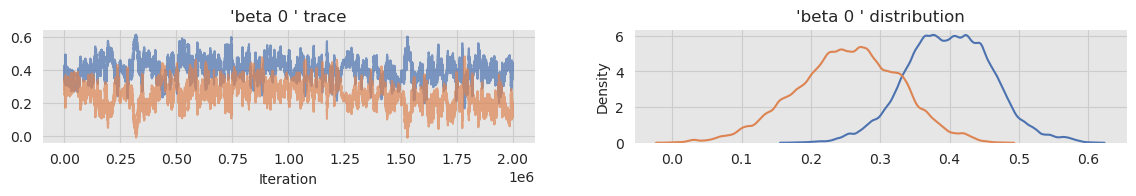

In [84]:
def plot_traces(var_name, samples):
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    print(samples.shape, (samples.numpy()).shape, chain)
    s = samples.numpy()[:, chain]
    axes[0].plot(s, alpha=0.7)
    sns.kdeplot(s, ax=axes[1], shade=False)
    axes[0].title.set_text("'{}' trace".format(var_name))
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')

#warnings.filterwarnings('ignore')
for var, var_samples in hmc_samples.items():
  plot_traces(var, var_samples)



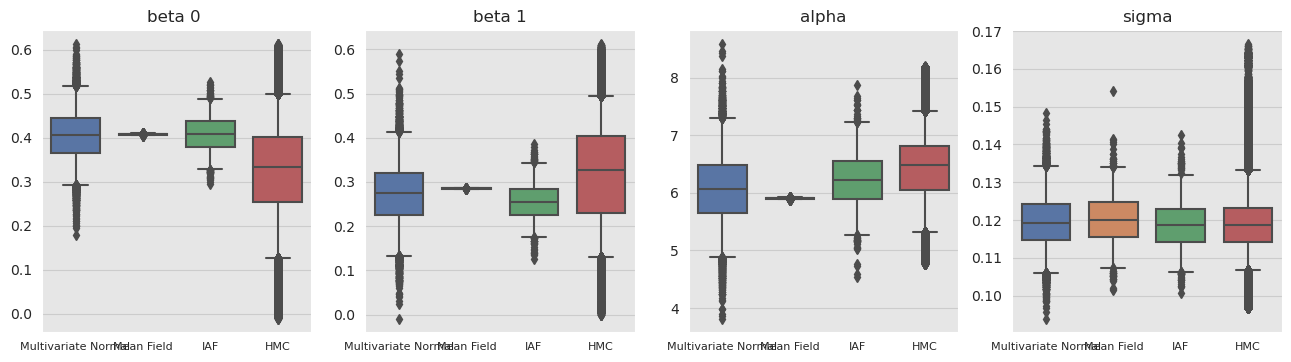

In [85]:
results['HMC'] = hmc_samples
plot_boxplot(results)

